This model learns the odd-even program. Since it was difficult to set a threshold, a winner take all is used for cleanup in the associative memories.

In [1]:
import nengo
import nengo_gui
import nengo.spa as spa
from nengo.spa import Vocabulary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dim = 64*2
rng = np.random.RandomState(12)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.02, unitary=True)

incr = vocab.parse("INCREMENT")
parity = vocab.parse("PARITY")

vocab.parse("ZERO")
vocab.add("ONE", vocab.parse("ZERO*INCREMENT"))
vocab.add("TWO", vocab.parse("ONE*INCREMENT"))
vocab.add("THREE", vocab.parse("TWO*INCREMENT"))
vocab.add("FOUR", vocab.parse("THREE*INCREMENT"))
vocab.add("FIVE", vocab.parse("FOUR*INCREMENT"))
vocab.add("SIX", vocab.parse("FIVE*INCREMENT"))
vocab.add("SEVEN", vocab.parse("SIX*INCREMENT"))
vocab.add("EIGHT", vocab.parse("SEVEN*INCREMENT"))
vocab.add("NINE", vocab.parse("EIGHT*INCREMENT"))
vocab.add("TEN", vocab.parse("NINE*INCREMENT"))
vocab.add("ELEVEN", vocab.parse("TEN*INCREMENT"))


zero = vocab.parse("NUMBER*ZERO+PARITY*EVEN")
one = vocab.parse("NUMBER*ONE+PARITY*ODD")
two = vocab.parse("NUMBER*TWO+PARITY*EVEN")
three = vocab.parse("NUMBER*THREE+PARITY*ODD")
four = vocab.parse("NUMBER*FOUR+PARITY*EVEN")
five = vocab.parse("NUMBER*FIVE+PARITY*ODD")
six = vocab.parse("NUMBER*SIX+PARITY*EVEN")
seven = vocab.parse("NUMBER*SEVEN+PARITY*ODD")
eight = vocab.parse("NUMBER*EIGHT+PARITY*EVEN")
nine = vocab.parse("NUMBER*NINE+PARITY*ODD")
ten = vocab.parse("NUMBER*TEN+PARITY*EVEN")
eleven = vocab.parse("NUMBER*ELEVEN+PARITY*ODD")

vocab.add("ZERO_W", zero)
vocab.add("ONE_W", one)
vocab.add("TWO_W", two)
vocab.add("THREE_W", three)
vocab.add("FOUR_W", four)
vocab.add("FIVE_W", five)
vocab.add("SIX_W", six)
vocab.add("SEVEN_W", seven)
vocab.add("EIGHT_W", eight)
vocab.add("NINE_W", nine)
vocab.add("TEN_W", ten)
vocab.add("ELEVEN_W", eleven)      

# create sub vocabs
par_vocab = vocab.create_subset(['ODD', 'EVEN'])
num_vocab = vocab.create_subset(['ZERO_W', 'ONE_W', 'TWO_W', 'THREE_W', 'FOUR_W', 'FIVE_W', 'SIX_W', 
                               'SEVEN_W', 'EIGHT_W', 'NINE_W', 'TEN_W', 'ELEVEN_W'])

/Users/sugandha/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=128, M=14)
  len(self.pointers)))
/Users/sugandha/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=128, M=15)
  len(self.pointers)))
/Users/sugandha/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.02 (D=128, M=16)
  len(self.pointers)))


In [3]:
model = spa.SPA() 
with model:
    model.a = spa.State(dim, vocab=vocab)
    model.b = spa.State(dim, vocab=vocab)
    model.trans = spa.State(dim, vocab=vocab, feedback=1)
    
    model.cue = spa.State(dim, vocab=vocab)
    model.succ = spa.State(dim, vocab=vocab)
    model.pred = spa.State(dim, vocab=vocab)
    model.assoc_memSucc = spa.AssociativeMemory(input_vocab=vocab, wta_output=True, threshold_output=True)
    model.assoc_memPred = spa.AssociativeMemory(input_vocab=vocab, wta_output=True, threshold_output=True)
    model.parity = spa.State(dim, vocab=vocab)
    
    actions = spa.Actions(
        'trans = ~a * b',
        'succ = trans*cue',
        'pred = ~trans*cue',
        'assoc_memSucc = succ',
        'assoc_memPred = pred',
        'parity = ~PARITY*assoc_memSucc',
    )

    model.cortical = spa.Cortical(actions)
    
    par_probe = nengo.Probe(model.parity.output, synapse=0.03)
    cue_probe = nengo.Probe(model.cue.output, synapse=0.03)
    
    succ_probe = nengo.Probe(model.succ.output, synapse=0.03)
    pred_probe = nengo.Probe(model.pred.output, synapse=0.03)
    
    amsucc_inprobe = nengo.Probe(model.assoc_memSucc.input)
    amsucc_outprobe = nengo.Probe(model.assoc_memSucc.output, synapse=0.03)
    
    ampred_inprobe = nengo.Probe(model.assoc_memPred.input)
    ampred_outprobe = nengo.Probe(model.assoc_memPred.output, synapse=0.03)

In [4]:
def inp1(t):
    if t <= 0.2:
        return 'ZERO_W'                               
    elif (0.2 < t<=0.4):      
        return 'ONE_W'
    elif (0.4 < t<=0.6):      
        return 'TWO_W' 
    else:
        return '0'
 
            
def inp2(t):
    if t <= 0.2:
        return 'ONE_W'                                
    elif (0.2 < t<=0.4):      
        return 'TWO_W'
    elif (0.4 < t<=0.6):      
        return 'THREE_W'
    else:
        return '0'
 
    
def cue_inp(t):
    if 0.6 < t <= 0.8:
        return 'SIX_W'
    else:
        return '0'

    
    
with model:
    model.input = spa.Input(a=inp1, b=inp2, cue=cue_inp)     # provide sensory input which determines cortex state

In [5]:
# normalize=True to compute cosine similarity
def plot_similarities(input_data,
                      output_data,
                      vocab1,
                      vocab2=None,
                      autoscale=False):
    if vocab2 is None:
        vocab2 = vocab1

    ymin, ymax = -1.2, 1.2
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.plot(t, spa.similarity(input_data, vocab1, normalize=True))
    plt.title("Input similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.legend(
        vocab1.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)

    plt.subplot(1, 2, 2)
    plt.plot(t, spa.similarity(output_data, vocab2, normalize=True))
    plt.title("Output similarity")
    plt.xlabel("Time")
    plt.xlim(right=t[-1])
    plt.ylim(ymin, ymax)
    if autoscale:
        plt.autoscale(autoscale, axis='y')
    plt.grid(True)
    plt.legend(
        vocab2.keys, loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)
    plt.tight_layout()

In [6]:
sim = nengo.Simulator(model)
sim.run(1.5)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/Users/sugandha/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

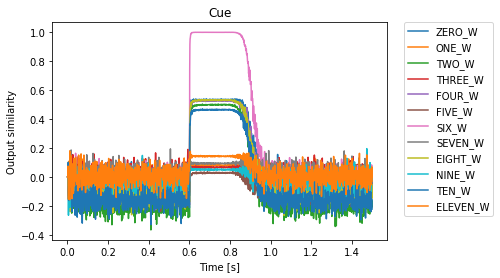

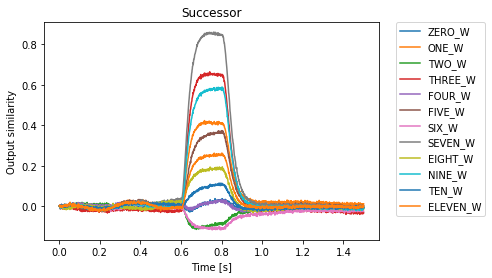

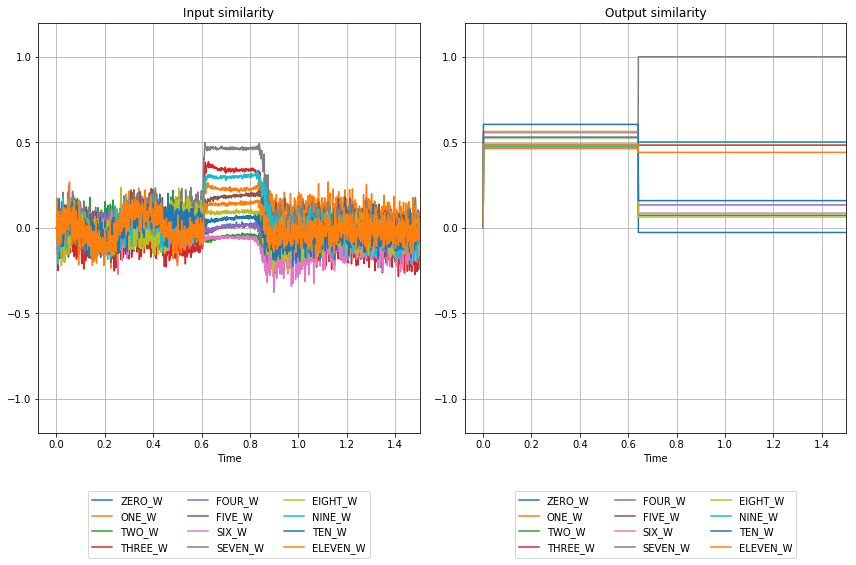

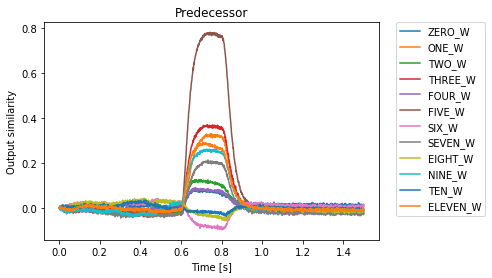

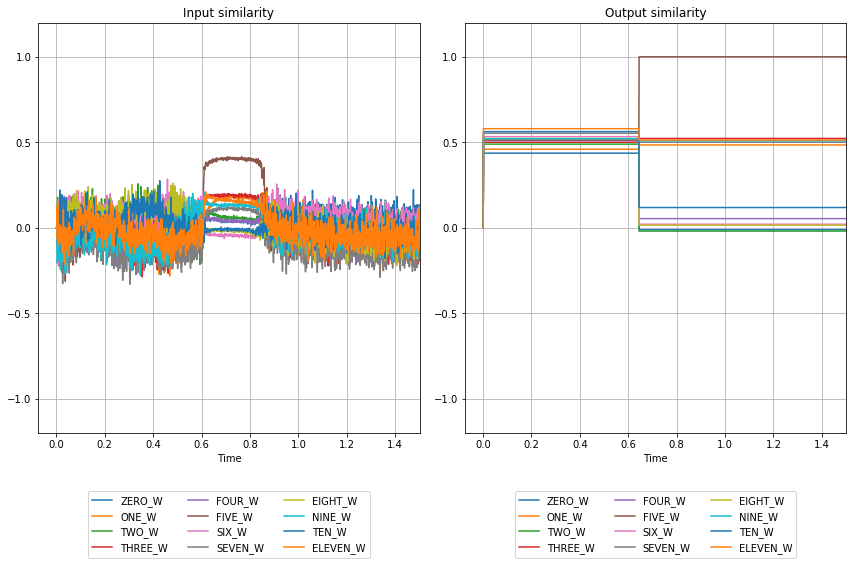

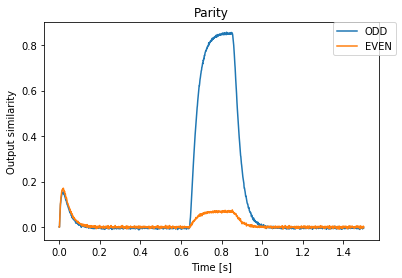

In [7]:
# Cue
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[cue_probe], num_vocab, normalize=True))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Cue")
plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);


# Successor
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[succ_probe], num_vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Successor")
plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

plot_similarities(sim.data[amsucc_inprobe], sim.data[amsucc_outprobe], num_vocab)

# Predecessor
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[pred_probe], num_vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Predecessor")
plt.legend(num_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

plot_similarities(sim.data[ampred_inprobe], sim.data[ampred_outprobe], num_vocab)

# Parity
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[par_probe], par_vocab))
plt.xlabel("Time [s]")
plt.ylabel("Output similarity")
plt.title("Parity")
plt.legend(par_vocab.keys, loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.0);

In [8]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model)

In [9]:
model.n_neurons

209500